In [5]:
from datetime import date

print(date.today())

2020-06-20


SIMPLE LSTM with word embedding to IMDB reviews practice with keras

In [6]:
import numpy as np 
import pandas as pd 

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(7)

In [9]:
# load data with 5000 top words constrains

top_words = 5000
(xtrain, ytrain), (xtest, ytest) = imdb.load_data(num_words= top_words)

In [10]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [11]:
# truncate and pad the input sequence to make it equal length for modeling
max_review_leng = 500
xtrain_pad = sequence.pad_sequences(xtrain, maxlen=max_review_leng)
xtest_pad = sequence.pad_sequences(xtest, maxlen=max_review_leng)

In [12]:
xtrain_pad.shape, xtest_pad.shape

((25000, 500), (25000, 500))

In [14]:
# modeling 
embedding_vector_leng = 32
model = Sequential([
    Embedding(top_words, embedding_vector_leng, input_length= max_review_leng),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

In [15]:
# compiling the model

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
# train the model and evaluate on test set

history = model.fit(xtrain_pad, ytrain, validation_data=(xtest_pad, ytest), 
          epochs= 3, batch_size= 64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 366s 15ms/step - loss: 0.3948 - accuracy: 0.8264 - val_loss: 0.3911 - val_accuracy: 0.8302
Epoch 2/3
25000/25000 [==============================] - 356s 14ms/step - loss: 0.3189 - accuracy: 0.8650 - val_loss: 0.3193 - val_accuracy: 0.8683
Epoch 3/3
25000/25000 [==============================] - 361s 14ms/step - loss: 0.2617 - accuracy: 0.8967 - val_loss: 0.3005 - val_accuracy: 0.8768


In [21]:
history.history

{'val_loss': [0.39105697257995603, 0.3192665366125107, 0.30049536427497864],
 'val_accuracy': [0.8301600217819214, 0.8683199882507324, 0.8767600059509277],
 'loss': [0.3947966867351532, 0.31894720456123354, 0.26165767252922056],
 'accuracy': [0.82636, 0.86504, 0.89668]}

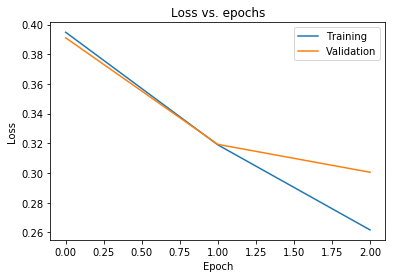

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

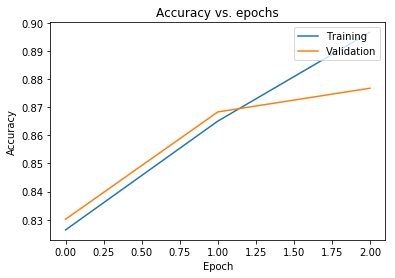

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

There is overfitting after one Epoch.. ? 

In [28]:
print("Accuracy: %.2f%%" % (history.history['val_accuracy'][2]*100))

Accuracy: 87.68%


Applying dropout to LSTM

One major issue in learning large networks is co-adaptation. In such a network, if all the weights are learned together it is common that some of the connections will have more predictive capability than the others.

In such a scenario, as the network is trained iteratively these powerful connections are learned more while the weaker ones are ignored. Over many iterations, only a fraction of the node connections is trained. And the rest stop participating.

This phenomenon is called co-adaptation. This could not be prevented with the traditional regularization, like the L1 and L2. The reason is they also regularize based on the predictive capability of the connections. Due to this, they become close to deterministic in choosing and rejecting weights. And, thus again, the strong gets stronger and the weak gets weaker.

In [29]:
# modeling with dropout 
from keras.layers import Dropout
model = Sequential([
    Embedding(top_words, embedding_vector_leng, input_length = max_review_leng), 
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2), 
    Dense(1, activation='sigmoid')
])

In [30]:
# compile 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [32]:
# training the model and evaluating on the test set
history = model.fit(xtrain_pad, ytrain, validation_data=(xtest_pad, ytest), epochs= 3, batch_size= 64, verbose= 2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
 - 344s - loss: 0.3666 - accuracy: 0.8458 - val_loss: 0.3308 - val_accuracy: 0.8639
Epoch 2/3
 - 399s - loss: 0.2862 - accuracy: 0.8867 - val_loss: 0.3750 - val_accuracy: 0.8363
Epoch 3/3
 - 401s - loss: 0.3006 - accuracy: 0.8808 - val_loss: 0.3543 - val_accuracy: 0.8558


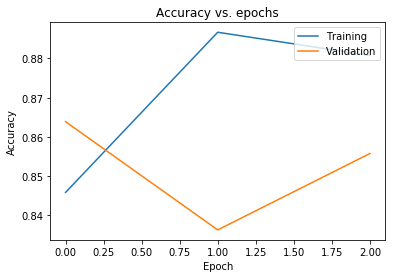

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

dropout having the desired impact on training with a slightly slower trend in convergence and in this case a lower final accuracy. The model could probably use a few more epochs of training and may achieve a higher skill 

In [39]:
print('Accuracy: %.2f%%' % (history.history['val_accuracy'][2]*100))

Accuracy: 85.58%


Using recurrent_droupout from LSTM

In [41]:
model = Sequential([
    Embedding(top_words, embedding_vector_leng, input_length= max_review_leng), 
    LSTM(100, dropout= 0.2, recurrent_dropout = 0.2), 
    Dense(1, activation= 'sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(xtrain_pad, ytrain, validation_data=(xtest_pad, ytest), epochs=3, batch_size=64)

C:\Users\caffr\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:353: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 356s 14ms/step - loss: 0.4991 - accuracy: 0.7543 - val_loss: 0.3543 - val_accuracy: 0.8520
Epoch 2/3
25000/25000 [==============================] - 382s 15ms/step - loss: 0.3629 - accuracy: 0.8492 - val_loss: 0.3664 - val_accuracy: 0.8409
Epoch 3/3
25000/25000 [==============================] - 385s 15ms/step - loss: 0.3262 - accuracy: 0.8702 - val_loss: 0.3808 - val_accuracy: 0.8482


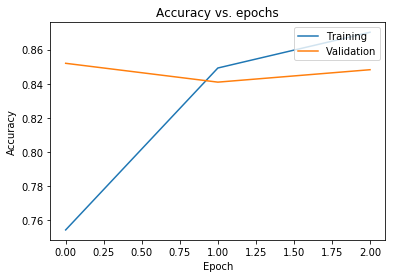

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    CNN that is excel at learning spatial structure may be able to pick out invariant features for good and bad sentiment, since imdb also has one-dimensional spatial structure in sequence. 

In [46]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential([
    Embedding(top_words, embedding_vector_leng, input_length =max_review_leng), 
    Conv1D(filters= 32, kernel_size = 3, padding = 'SAME', activation ='relu'),
    MaxPooling1D(pool_size = 2), 
    LSTM(100), 
    Dense(1, activation = 'sigmoid')
])

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(xtrain_pad, ytrain, validation_data=(xtest_pad, ytest), epochs= 3, batch_size= 64)

C:\Users\caffr\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:353: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 164s 7ms/step - loss: 0.4356 - accuracy: 0.7876 - val_loss: 0.3016 - val_accuracy: 0.8730
Epoch 2/3
25000/25000 [==============================] - 170s 7ms/step - loss: 0.2497 - accuracy: 0.9020 - val_loss: 0.2801 - val_accuracy: 0.8844
Epoch 3/3
25000/25000 [==============================] - 169s 7ms/step - loss: 0.2088 - accuracy: 0.9209 - val_loss: 0.3938 - val_accuracy: 0.8535


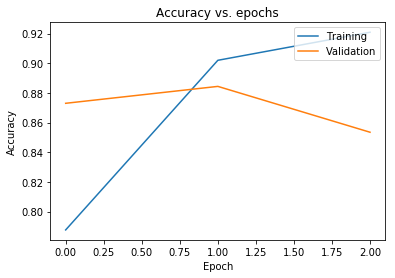

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()